In [ ]:
%pip install pydub librosa matplotlib "numpy<2" "tensorflow<2.11.0" "tensorflow-gpu<2.11.0"

In [1]:
import os
from pydub import AudioSegment

# 디렉토리 설정
input_dir = './m4a'
output_dir = './wav'

# 출력 디렉토리 생성
os.makedirs(output_dir, exist_ok=True)

# m4a 파일 리스트
files = [f for f in os.listdir(input_dir) if f.endswith('.m4a')]

slice_index = 1  # noise1.wav부터 시작

for file in files:
    m4a_path = os.path.join(input_dir, file)

    # m4a 파일 로드
    sound = AudioSegment.from_file(m4a_path, format="m4a")

    # 전체 길이를 1초 단위로 자르기
    full_seconds = len(sound) // 1000  # 남는 부분은 버림

    for i in range(full_seconds):
        start = i * 1000
        end = start + 1000
        segment = sound[start:end]

        # 출력 파일 경로: noise1.wav, noise2.wav, ...
        output_filename = f"noise{slice_index}.wav"
        output_path = os.path.join(output_dir, output_filename)

        # 저장
        segment.export(output_path, format="wav")
        slice_index += 1


In [8]:
import numpy as np
import librosa

# RMS 추출 함수
def extract_rms_from_file(file_path, frame_length=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    return rms, sr

# 시퀀스 생성 함수
def create_sequences(data, window_size, stride=5):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [9]:
import os
import numpy as np

# 경로 및 파라미터 설정
wav_dir = './wav'
window_size = 20

# 전체 데이터 수집
X_all, y_all = [], []

for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        rms, sr = extract_rms_from_file(file_path)
        X, y = create_sequences(rms, window_size)
        X_all.append(X)
        y_all.append(y)

# 하나의 큰 배열로 합치기
X_total = np.concatenate(X_all, axis=0)
y_total = np.concatenate(y_all, axis=0)

# LSTM 입력 형식으로 변형
X_total = X_total.reshape((X_total.shape[0], X_total.shape[1], 1))

print(f'총 시퀀스 개수: {X_total.shape[0]}, 입력 shape: {X_total.shape}')
print(f'총 레이블 개수: {y_total.shape[0]}, 레이블 shape: {y_total.shape}')

총 시퀀스 개수: 39282, 입력 shape: (39282, 20, 1)
총 레이블 개수: 39282, 레이블 shape: (39282,)


In [11]:
print(X_total[0].flatten()) # 첫 번째 시퀀스 출력
print(y_total[0]) # 첫 번째 레이블 출력

[0.         0.00095597 0.04456605 0.06113401 0.07354543 0.08515146
 0.08317228 0.08389068 0.08674265 0.08750504 0.0908769  0.09072655
 0.08754595 0.08558008 0.08159105 0.0783785  0.07564511 0.0737889
 0.07197184 0.07130171]
0.07169764


Epoch 1/50
983/983 [==============================] - 8s 6ms/step - loss: 1.7965e-04 - val_loss: 4.3016e-05
Epoch 2/50
983/983 [==============================] - 7s 7ms/step - loss: 5.9222e-05 - val_loss: 3.1019e-05
Epoch 3/50
983/983 [==============================] - 6s 6ms/step - loss: 5.4307e-05 - val_loss: 3.0090e-05
Epoch 4/50
983/983 [==============================] - 6s 6ms/step - loss: 5.4385e-05 - val_loss: 3.7594e-05
Epoch 5/50
983/983 [==============================] - 6s 6ms/step - loss: 5.3683e-05 - val_loss: 3.2927e-05
Epoch 6/50
983/983 [==============================] - 6s 6ms/step - loss: 5.2340e-05 - val_loss: 3.9966e-05
Epoch 7/50
983/983 [==============================] - 5s 6ms/step - loss: 5.1302e-05 - val_loss: 2.8892e-05
Epoch 8/50
983/983 [==============================] - 5s 5ms/step - loss: 4.5980e-05 - val_loss: 2.8476e-05
Epoch 9/50
983/983 [==============================] - 5s 5ms/step - loss: 4.4629e-05 - val_loss: 2.6242e-05
Epoch 10/50
983/983 [=======

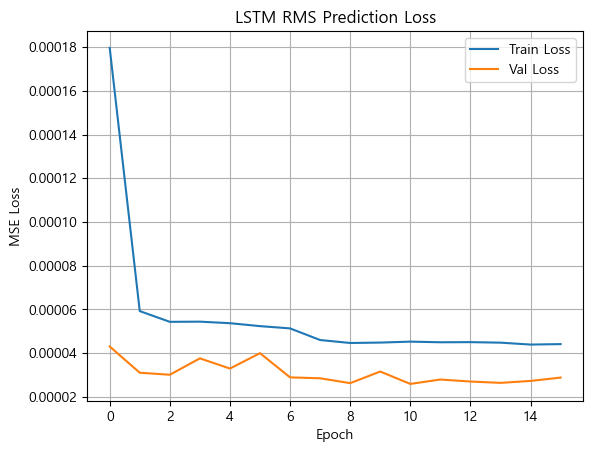

In [12]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import matplotlib.pyplot as plt

# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(X_total.shape[1], 1)),
    Dense(1)  # 다음 시점의 RMS 값을 예측
])

model.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_total, y_total,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 모델 저장
model.save('lstm_rms_model.h5')

# 학습 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM RMS Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from tensorflow.keras.models import load_model  # type: ignore

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 디렉토리 설정
wav_dir = './wav'
prediction_dir = './prediction'
os.makedirs(prediction_dir, exist_ok=True)

# 하이퍼파라미터
window_size = 20
stride = 10
frame_length = 2048
hop_length = 512

# 모델 불러오기
model = load_model('lstm_rms_model.h5')

# 예측 및 시각화
for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        rms, sr = extract_rms_from_file(file_path, frame_length, hop_length)

        # 시간 벡터 생성
        frames = np.arange(len(rms))
        times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

        # 시퀀스 생성
        X, y_true = create_sequences(rms, window_size, stride=stride)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        # 예측
        y_pred = model.predict(X).flatten()

        # 예측용 x축 (시간 단위)
        pred_times = times[window_size::stride][:len(y_pred)]

        # 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(times, rms, label='Original RMS')
        plt.plot(pred_times, y_pred, label='Predicted RMS', color='orange')
        plt.title(f'{filename} - RMS Prediction')
        plt.xlabel('Time (s)')
        plt.ylabel('RMS')
        plt.legend()
        plt.grid(True)

        # 저장
        prediction_file_path = os.path.join(prediction_dir, f'{os.path.splitext(filename)[0]}_prediction.png')
        plt.savefig(prediction_file_path)
        plt.close()


In [15]:
import numpy as np
import librosa

# 특징 추출 함수
def extract_features_from_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y)[0]
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    zero_crossing = librosa.feature.zero_crossing_rate(y)[0]

    # 최소 길이 맞춤
    min_len = min(len(rms), len(centroid), len(bandwidth), len(zero_crossing))
    features = np.vstack([
        rms[:min_len],
        centroid[:min_len],
        bandwidth[:min_len],
        zero_crossing[:min_len]
    ]).T

    return features, sr

# 시퀀스 생성 함수 (다변량)
def create_multivariate_sequences(data, window_size, stride=5):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])  # 다음 시점의 전체 feature 예측
    return np.array(X), np.array(y)

In [16]:
import os
import numpy as np

wav_dir = './wav'
window_size = 20
stride = 10

X_total, y_total = [], []

for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        path = os.path.join(wav_dir, filename)
        features, _ = extract_features_from_file(path)
        X_seq, y_seq = create_multivariate_sequences(features, window_size, stride=stride)
        X_total.append(X_seq)
        y_total.append(y_seq)

X_total = np.vstack(X_total)
y_total = np.vstack(y_total)

print(f'총 시퀀스 개수: {X_total.shape[0]}, 입력 shape: {X_total.shape}')
print(f'총 레이블 개수: {y_total.shape[0]}, 레이블 shape: {y_total.shape}')

총 시퀀스 개수: 20060, 입력 shape: (20060, 20, 4)
총 레이블 개수: 20060, 레이블 shape: (20060, 4)


Epoch 1/50
502/502 [==============================] - 9s 11ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 2/50
502/502 [==============================] - 5s 11ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/50
502/502 [==============================] - 6s 11ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/50
502/502 [==============================] - 5s 10ms/step - loss: 8.4027e-04 - val_loss: 9.0548e-04
Epoch 5/50
502/502 [==============================] - 5s 9ms/step - loss: 7.3991e-04 - val_loss: 8.7219e-04
Epoch 6/50
502/502 [==============================] - 5s 10ms/step - loss: 6.9934e-04 - val_loss: 8.0909e-04
Epoch 7/50
502/502 [==============================] - 5s 11ms/step - loss: 6.8361e-04 - val_loss: 8.1217e-04
Epoch 8/50
502/502 [==============================] - 5s 10ms/step - loss: 6.6689e-04 - val_loss: 8.7086e-04
Epoch 9/50
502/502 [==============================] - 5s 9ms/step - loss: 6.5032e-04 - val_loss: 7.7958e-04
Epoch 10/50
502/502 [========================

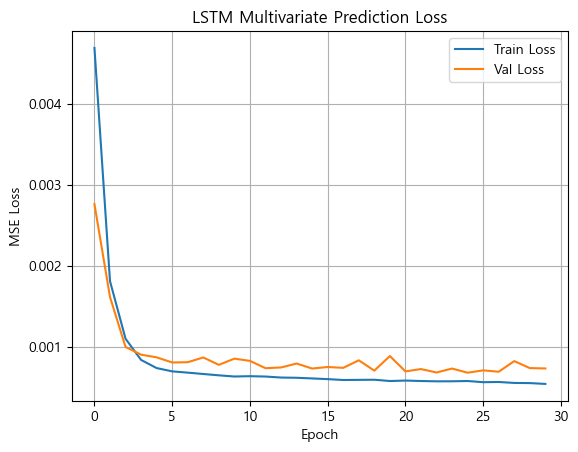

In [17]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from joblib import dump

scaler = MinMaxScaler()
X_total_scaled = scaler.fit_transform(X_total.reshape(-1, X_total.shape[-1])).reshape(X_total.shape)
y_total_scaled = scaler.fit_transform(y_total)
dump(scaler, 'scaler_y.joblib')

# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(window_size, 4), return_sequences=True),
    TimeDistributed(Dense(64)),  # 시계열 각 시점별로 Dense(32) 적용
    LSTM(32),
    Dense(16),
    Dense(4)  # 다음 시점의 모든 feature 예측: [RMS, 중심주파수, 주파수폭, 제로크로싱]
])

model.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_total_scaled, y_total_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 모델 저장
model.save('lstm_all_feature_predictor.h5')

# 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Multivariate Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model # type: ignore
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
from joblib import load

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

feature_dir = './feature_prediction'
os.makedirs(feature_dir, exist_ok=True)

stride=10
hop_length=512

# 모델 로드
model = load_model('lstm_all_feature_predictor.h5')
scaler = load('scaler_y.joblib')

# 예측 및 시각화
for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        path = os.path.join(wav_dir, filename)
        features, sr = extract_features_from_file(path)
        X, y_true = create_multivariate_sequences(features, window_size, stride=stride)
        X_scaled = scaler.transform(X.reshape(-1, 4)).reshape(X.shape)

        y_pred_scaled = model.predict(X_scaled)
        y_pred = scaler.inverse_transform(y_pred_scaled)  # 역정규화

        # 시간축
        frames = np.arange(len(features))
        times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
        pred_times = times[window_size::stride][:len(y_pred)]

        # 시각화
        feature_names = ['RMS', 'Centroid', 'Bandwidth', 'ZCR']
        for i in range(4):
            plt.figure(figsize=(10, 4))
            plt.plot(times, features[:, i], label=f'Original {feature_names[i]}')
            plt.plot(pred_times, y_pred[:, i], label=f'Predicted {feature_names[i]}', color='orange')
            plt.title(f'{filename} - {feature_names[i]} Prediction')
            plt.xlabel('Time (s)')
            plt.ylabel(feature_names[i])
            plt.legend()
            plt.grid(True)

            save_path = os.path.join(feature_dir, f"{os.path.splitext(filename)[0]}_{feature_names[i]}.png")
            plt.savefig(save_path)
            plt.close()

In [ ]:
#  1. 라이브러리 임포트
import os
import numpy as np
import librosa
import joblib
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
from sklearn.preprocessing import MinMaxScaler

#  2. 상수 설정
SAMPLE_RATE = 16000
FRAME_DURATION = 0.05
FRAME_SIZE = int(SAMPLE_RATE * FRAME_DURATION)
SEQUENCE_LENGTH = 5
P0 = 20e-6  # 기준압력 (20 µPa)

#  3. 주파수 및 위상 추정 함수
def estimate_frequency(signal, sr):
    fft = np.fft.rfft(signal)
    magnitude = np.abs(fft)
    freqs = np.fft.rfftfreq(len(signal), 1/sr)
    peak_idx = np.argmax(magnitude)
    return freqs[peak_idx]

def estimate_phase(signal, freq, sr):
    t = np.arange(len(signal)) / sr
    phase_shift = np.angle(np.sum(signal * np.exp(-1j * 2 * np.pi * freq * t)))
    return phase_shift

#  4. 특징 추출 함수: freq, amp(FFT peak amplitude 기반 dB), phase
def amplitude_to_db(amp, p0=P0, min_db=-80):
    amp = np.maximum(amp, 1e-20)  # 로그 0 방지
    db = 20 * np.log10(amp / p0)
    db = np.maximum(db, min_db)
    return db

def extract_features(signal):
    fft = np.fft.rfft(signal)
    magnitude = np.abs(fft)
    freqs = np.fft.rfftfreq(len(signal), 1/SAMPLE_RATE)

    peak_idx = np.argmax(magnitude)
    freq = freqs[peak_idx]
    peak_amp = magnitude[peak_idx]

    amp_db = amplitude_to_db(peak_amp)
    phase = np.angle(fft[peak_idx])

    return np.array([freq, amp_db, phase], dtype=np.float32)


In [75]:
# 📌 5. 전체 wav 폴더에서 데이터셋 로딩
def load_dataset(folder_path):
    X_all, y_all = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            filepath = os.path.join(folder_path, filename)
            signal, _ = librosa.load(filepath, sr=SAMPLE_RATE)

            features = []
            for i in range(0, len(signal) - FRAME_SIZE, FRAME_SIZE):
                frame = signal[i:i + FRAME_SIZE]
                feature = extract_features(frame)
                features.append(feature)

            features = np.array(features)

            # 예측할 길이 설정 (미래 10프레임)
            PREDICT_LENGTH = 10

            for i in range(len(features) - SEQUENCE_LENGTH - PREDICT_LENGTH):
                X_seq = features[i:i + SEQUENCE_LENGTH]  # (SEQUENCE_LENGTH, 3)
                y_seq = features[i + SEQUENCE_LENGTH:i + SEQUENCE_LENGTH + PREDICT_LENGTH]  # (10, 3)
                y_flat = y_seq.flatten()  # (10 * 3 = 30,)

                X_all.append(X_seq)
                y_all.append(y_flat)

    return np.array(X_all), np.array(y_all)

In [76]:
X, y = load_dataset('./wav')
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10984, 5, 3)
y shape: (10984, 30)


In [78]:
# 📌 6. 데이터 로딩 및 분할
X, y = load_dataset('./wav')  # 학습용 wav 폴더 경로
print(f"전체 샘플 수: {len(X)}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

num_samples, time_steps, num_features = X_train.shape

# 타겟 정규화 (예: 주파수, 진폭, 위상)
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)

X_train_2d = X_train.reshape(num_samples, time_steps * num_features)
scaler_x = MinMaxScaler().fit(X_train_2d)
scaler_y = MinMaxScaler().fit(y_train)   # shape=(?, 3)

joblib.dump(scaler_x, 'scaler_x.joblib')
joblib.dump(scaler_y, 'scaler_y.joblib')

# EarlyStopping: val_loss가 5 epoch 이상 개선되지 않으면 종료
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# ModelCheckpoint: 가장 좋은 val_loss 모델 저장
model_checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True, verbose=1
)

# 📌 7. 모델 정의
model = Sequential([
    LSTM(64, input_shape=(SEQUENCE_LENGTH, 3), return_sequences=True),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(30)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


# 학습 시 scaled된 y 사용
model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=30,
    callbacks=[early_stopping, model_checkpoint]
)

전체 샘플 수: 10984
Epoch 1/30
308/309 [============================>.] - ETA: 0s - loss: 0.0447 - mae: 0.1473
Epoch 1: val_loss improved from inf to 0.03637, saving model to best_model.h5
309/309 [==============================] - 6s 10ms/step - loss: 0.0447 - mae: 0.1472 - val_loss: 0.0364 - val_mae: 0.1292
Epoch 2/30
307/309 [============================>.] - ETA: 0s - loss: 0.0371 - mae: 0.1306
Epoch 2: val_loss did not improve from 0.03637
309/309 [==============================] - 2s 8ms/step - loss: 0.0371 - mae: 0.1306 - val_loss: 0.0365 - val_mae: 0.1265
Epoch 3/30
306/309 [============================>.] - ETA: 0s - loss: 0.0371 - mae: 0.1301
Epoch 3: val_loss did not improve from 0.03637
309/309 [==============================] - 2s 7ms/step - loss: 0.0371 - mae: 0.1300 - val_loss: 0.0368 - val_mae: 0.1279
Epoch 4/30
308/309 [============================>.] - ETA: 0s - loss: 0.0364 - mae: 0.1276
Epoch 4: val_loss improved from 0.03637 to 0.03595, saving model to best_model.h5
309

노이즈 캔슬링 시작 (Ctrl+C로 종료)
직접 반대파 생성 (freq, amp_db, phase): 6460.00 Hz, 0.00 dB SPL, -1.9943 rad
직접 반대파 생성 (freq, amp_db, phase): 840.00 Hz, 0.00 dB SPL, -0.4057 rad
직접 반대파 생성 (freq, amp_db, phase): 2010.00 Hz, 0.00 dB SPL, -1.9335 rad
직접 반대파 생성 (freq, amp_db, phase): 6010.00 Hz, 0.00 dB SPL, 1.5162 rad
직접 반대파 생성 (freq, amp_db, phase): 6270.00 Hz, 0.00 dB SPL, 0.9280 rad
직접 반대파 생성 (freq, amp_db, phase): 4090.00 Hz, 0.00 dB SPL, -1.7918 rad
직접 반대파 생성 (freq, amp_db, phase): 290.00 Hz, 0.00 dB SPL, 2.5036 rad
직접 반대파 생성 (freq, amp_db, phase): 1060.00 Hz, 0.00 dB SPL, 1.4352 rad
직접 반대파 생성 (freq, amp_db, phase): 1890.00 Hz, 0.00 dB SPL, -1.9356 rad
직접 반대파 생성 (freq, amp_db, phase): 6790.00 Hz, 0.00 dB SPL, -2.1149 rad
직접 반대파 생성 (freq, amp_db, phase): 1300.00 Hz, 0.00 dB SPL, 2.1190 rad
직접 반대파 생성 (freq, amp_db, phase): 4590.00 Hz, 0.00 dB SPL, -2.7784 rad
직접 반대파 생성 (freq, amp_db, phase): 480.00 Hz, 0.00 dB SPL, 0.6041 rad
직접 반대파 생성 (freq, amp_db, phase): 7940.00 Hz, 0.00 dB SPL, -2.5548 rad
직접 반대

C:\Users\user\AppData\Local\Temp\ipykernel_11088\2764253381.py:160: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_11088\2764253381.py:160: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_11088\2764253381.py:160: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_11088\2764253381.py:160: UserWarning: Glyph 128995 (\N{LARGE PURPLE CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128995 (\N{LARGE PURPLE CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


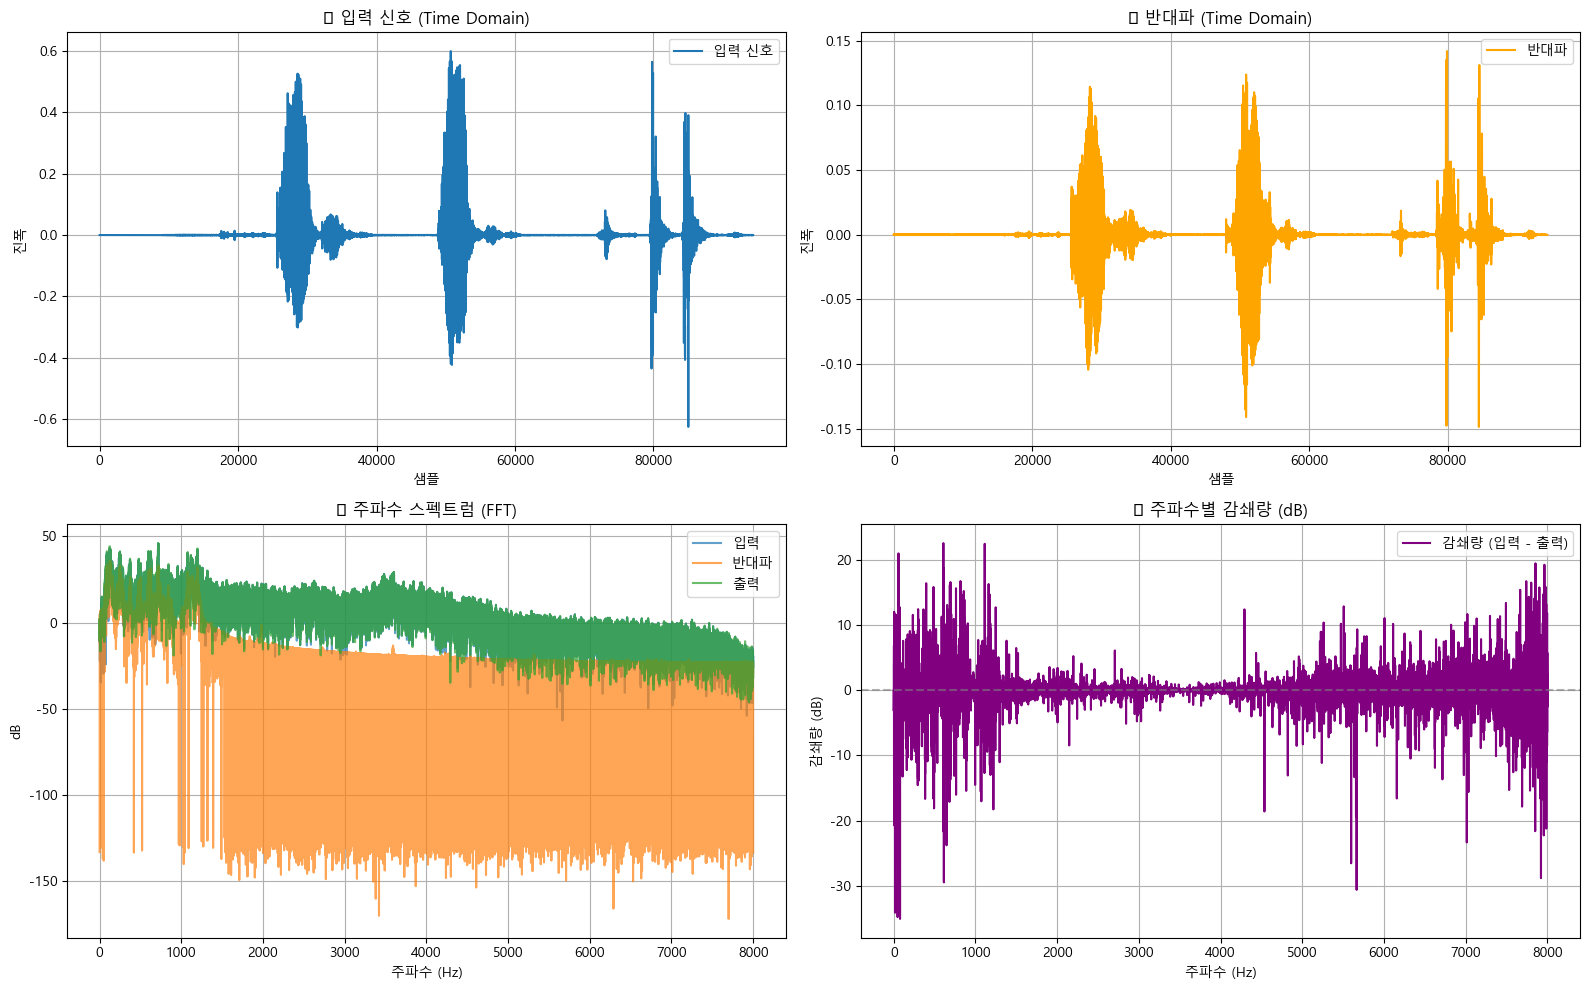

In [4]:
import numpy as np
import sounddevice as sd
import time
import queue
import threading
import matplotlib.pyplot as plt
import matplotlib
import platform

# 폰트 설정
if platform.system() == 'Windows':
    matplotlib.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    matplotlib.rc('font', family='AppleGothic')
else:
    matplotlib.rc('font', family='NanumGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

SAMPLE_RATE = 16000
FRAME_DURATION = 0.1
FRAME_SIZE = int(SAMPLE_RATE * FRAME_DURATION)
P0 = 20e-6

input_q = queue.Queue()
output_q = queue.Queue()

# 🟢 시각화를 위한 기록용 리스트
input_frames = []
anti_frames = []
output_frames = []

def extract_peaks(frame, threshold_db=-30, max_peaks=10):
    N = len(frame)
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft) / N
    freqs = np.fft.rfftfreq(N, 1 / SAMPLE_RATE)
    phases = np.angle(fft)
    
    amp_db = 20 * np.log10(magnitude / P0 + 1e-12)
    candidate_idx = np.where(amp_db > threshold_db)[0]
    
    if len(candidate_idx) > 0:
        sorted_idx = candidate_idx[np.argsort(amp_db[candidate_idx])[::-1]]
        peak_idx = sorted_idx[:max_peaks]
    else:
        peak_idx = []
    
    peaks = []
    for idx in peak_idx:
        freq = freqs[idx]
        db = np.clip(amp_db[idx], 0, 150)
        phase = phases[idx]
        peaks.append((freq, db, phase))
    return peaks

def generate_multi_anti_wave(peaks, length):
    t = np.arange(length) / SAMPLE_RATE
    wave = np.zeros(length, dtype=np.float32)
    for freq, amp_db, phase in peaks:
        amp_actual = P0 * (10 ** (amp_db / 20))
        amp_actual = np.clip(amp_actual, 0.0, 0.02)
        wave += -amp_actual * np.sin(2 * np.pi * freq * t + phase)
    return wave

def worker():
    while True:
        frame = input_q.get()
        if frame is None:
            break
        
        peaks = extract_peaks(frame)
        anti_wave = generate_multi_anti_wave(peaks, len(frame))
        output_q.put(anti_wave)
        
        for freq, amp_db, phase in peaks:
            print(f"직접 반대파 생성 (freq, amp_db, phase): {freq:.2f} Hz, {amp_db:.2f} dB SPL, {phase:.4f} rad")

def audio_callback(indata, outdata, frames, time_info, status):
    if status:
        print(status)

    input_frame = indata[:, 0].copy()
    input_q.put(input_frame)

    try:
        anti_wave = output_q.get(timeout=0.02)
        mixed = input_frame + anti_wave
        mixed = np.clip(mixed, -1.0, 1.0)
        outdata[:, 0] = mixed

        # 🔴 기록용 저장
        input_frames.append(input_frame.copy())
        anti_frames.append(anti_wave.copy())
        output_frames.append(mixed.copy())

    except queue.Empty:
        outdata.fill(0)

# ... 생략: 기존 import 및 설정

def plot_results():
    def to_db(sig):
        return 20 * np.log10(np.abs(np.fft.rfft(sig)) + 1e-12)

    input_sig = np.concatenate(input_frames)
    anti_sig = np.concatenate(anti_frames)
    output_sig = np.concatenate(output_frames)

    freqs = np.fft.rfftfreq(len(input_sig), 1 / SAMPLE_RATE)

    input_db = to_db(input_sig)
    anti_db = to_db(anti_sig)
    output_db = to_db(output_sig)
    
    # 🔷 감쇄량 계산
    diff_db = input_db - output_db

    plt.figure(figsize=(16, 10))

    # 시간 도메인 - 입력
    plt.subplot(2, 2, 1)
    plt.plot(input_sig, label="입력 신호")
    plt.title("🟢 입력 신호 (Time Domain)")
    plt.xlabel("샘플")
    plt.ylabel("진폭")
    plt.grid()
    plt.legend()

    # 시간 도메인 - 반대파
    plt.subplot(2, 2, 2)
    plt.plot(anti_sig, label="반대파", color='orange')
    plt.title("🔴 반대파 (Time Domain)")
    plt.xlabel("샘플")
    plt.ylabel("진폭")
    plt.grid()
    plt.legend()

    # 주파수 도메인 - 입력/반대파/출력
    plt.subplot(2, 2, 3)
    plt.plot(freqs, input_db, label="입력", alpha=0.7)
    plt.plot(freqs, anti_db, label="반대파", alpha=0.7)
    plt.plot(freqs, output_db, label="출력", alpha=0.7)
    plt.title("🔵 주파수 스펙트럼 (FFT)")
    plt.xlabel("주파수 (Hz)")
    plt.ylabel("dB")
    plt.grid()
    plt.legend()

    # 🔷 감쇄량 도메인
    plt.subplot(2, 2, 4)
    plt.plot(freqs, diff_db, label="감쇄량 (입력 - 출력)", color='purple')
    plt.axhline(0, linestyle='--', color='gray', alpha=0.6)
    plt.title("🟣 주파수별 감쇄량 (dB)")
    plt.xlabel("주파수 (Hz)")
    plt.ylabel("감쇄량 (dB)")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# 나머지 전체 코드는 그대로 유지

if __name__ == "__main__":
    threading.Thread(target=worker, daemon=True).start()

    print("노이즈 캔슬링 시작 (Ctrl+C로 종료)")
    try:
        with sd.Stream(channels=1, samplerate=SAMPLE_RATE, blocksize=FRAME_SIZE, callback=audio_callback):
            while True:
                time.sleep(0.1)
    except KeyboardInterrupt:
        print("종료 신호 감지, 작업 종료 중...")
        input_q.put(None)
        time.sleep(0.5)  # 잔여 처리 시간 확보
        plot_results()